In [1]:
import sys
import yaml
with open('..//secrets.yml', 'r') as file:
    secrets = yaml.safe_load(file)
sys.path.append(secrets['elo_proj_path'])

In [2]:
from player_club_classes import team_elo, Player, Club, Match
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly
import pickle
import datetime

from support_files.team_colors import team_color_dict
from IPython.display import display
pd.options.display.max_columns = None

team_colors = pd.DataFrame(team_color_dict).T
team_colors.columns = ['Primary', 'Secondary']
team_colors = team_colors.rename_axis('Team').reset_index()

from plotly.validators.scatter.marker import SymbolValidator
raw_symbols = SymbolValidator().values

simple_symbols = [i for i in raw_symbols if str(i).isalpha()]

with open('../../Rugby_ELO/processed_data/playerbase.pickle', 'rb') as handle:
    playerbase = pickle.load(handle)
with open('../../Rugby_ELO/processed_data/matchlist.pickle', 'rb') as handle:
    matchlist = pickle.load(handle)
with open('../../Rugby_ELO/processed_data/teamlist.pickle', 'rb') as handle:
    teamlist = pickle.load(handle)

In [31]:
match_list = []
for _, match in matchlist.items():
    match_list.append({
        key: val for key, val in vars(match).items()
        #if key not in ['home_team', 'away_team']
        })

match_df = pd.DataFrame(match_list)
#match_df = match_df.drop(['home_team', 'away_team', 'commentary_df'], axis = 1)
match_df = match_df[~match_df.point_diff.isna()]

In [4]:
player_elo_list = []
for player_name, player in playerbase.items():
    player_elo = pd.DataFrame(player.elo_list, columns = [
        'Number', 'Full_Name', 'Team', 'Player', 'Position', 'Tries',
        'Try Assists', 'Conversion Goals', 'Penalty Goals',
        'Drop Goals Converted', 'Points', 'Passes', 'Runs', 'Meters Run',
        'Clean Breaks', 'Defenders Beaten', 'Offload', 'Turnovers Conceded',
        'Tackles', 'Missed Tackles', 'Lineouts Won', 'Penalties Conceded',
        'Yellow Cards', 'Red Cards', 'espn_id_num', 'Competition', 'Date',
        'Home Team', 'Home Score', 'Away Team', 'Away Score', 'Minutes',
        'Position_Number', 'gameid', 'Unicode_ID', 'comp_level', 'start_elo', 'end_elo'
       ])
    player_elo['Full Name'] = player_name[0]
    player_elo['Unicode_ID'] = player_name[1]
    player_elo_list.append(player_elo)

player_elo = pd.concat(player_elo_list).reset_index(drop=True)
player_elo = pd.merge(player_elo, team_colors, on = 'Team', how = 'left')
player_elo['elo_change'] = player_elo.end_elo - player_elo.start_elo
player_elo.Date = pd.to_datetime(player_elo.Date)

player_elo['week_num'] = player_elo['Date'].dt.isocalendar().week
player_elo['month'] = player_elo['Date'].dt.month
player_elo['year'] = player_elo['Date'].dt.year

player_elo.loc[player_elo.Position == 'BR', 'Position'] = 'N8'

starters = player_elo[player_elo.Position != 'R']
starters = starters.dropna(subset=['Position'])

In [5]:
#monthly_percentiles
from plot_functions import *

starters = player_elo[player_elo.Position != 'R']
starters = starters.dropna(subset=['Position'])
last_date_of_months = player_elo.groupby(pd.Grouper(key="Date", freq='M')).Date.max()
percentile_list = []

for date in last_date_of_months:
    current_players = starters[starters.Date < date]
    current_players = current_players[current_players.Date >= date - datetime.timedelta(days=365)]
    current_players = current_players[current_players.groupby(['Full Name'])['Date'].transform(max) == current_players['Date']].copy()
    percentile_df = current_players.groupby('Position')['end_elo'].quantile([0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]).reset_index()
    percentile_df.columns = ['Position', 'Percentile', 'elo']
    percentile_df = percentile_df.pivot(index = 'Position', columns = 'Percentile')
    percentile_df.columns = ["Percentile_" + str(int(x*100)) for x in percentile_df.columns.droplevel()]
    percentile_df = percentile_df.reset_index()
    percentile_df['year'] = date.year
    percentile_df['month'] = date.month

    mean_df = current_players.groupby('Position')['end_elo'].mean().reset_index()
    mean_df.columns = ['Position', 'elo_mean']
    percentile_df = percentile_df.merge(mean_df)

    percentile_list.append(percentile_df)
    
percentile_df = pd.concat(percentile_list)
percentile_df['dates'] = pd.to_datetime(percentile_df['year'].astype(int).astype(str)  + percentile_df['month'].astype(int).astype(str).str.pad(2, fillchar = '0'), format='%Y%m')

percentile_df.tail()

,Position,Percentile_5,Percentile_10,Percentile_25,Percentile_50,Percentile_75,Percentile_90,Percentile_95,year,month,elo_mean,dates
5,L,75.011483,77.099297,80.079265,87.454725,100.730333,110.417997,117.539549,2022.0,10.0,91.052876,2022-10-01
6,N8,75.437645,77.491620,80.819692,90.091618,101.220128,110.963306,116.111706,2022.0,10.0,92.114439,2022-10-01
7,P,74.769619,77.293005,79.570171,85.024271,99.496033,108.894706,113.714101,2022.0,10.0,89.961264,2022-10-01
8,SH,75.894026,77.288991,79.476348,86.620467,100.985685,110.525464,116.003259,2022.0,10.0,90.809172,2022-10-01
9,W,74.272347,76.432199,79.211884,83.593588,97.860698,110.683202,116.945200,2022.0,10.0,89.332982,2022-10-01


In [6]:
plt.rcParams['figure.figsize'] = [15, 7]

Text(0.5, 1.0, 'Median')

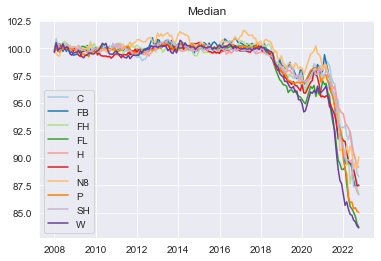

In [7]:
positions = percentile_df.Position.unique()
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99']
cmap = zip(positions, colors[0:len(positions)])  # zip values to colors

for position, color in cmap:
    plt_set = percentile_df[percentile_df.Position == position]
    plt.plot(plt_set.dates, plt_set.Percentile_50, c=color)

plt.legend(positions)
plt.title('Median')
## Definitely have some rating deflation. Not great

Text(0.5, 1.0, 'Mean')

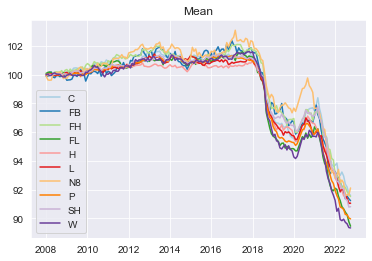

In [8]:
positions = percentile_df.Position.unique()
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99']
cmap = zip(positions, colors[0:len(positions)])  # zip values to colors

for position, color in cmap:
    plt_set = percentile_df[percentile_df.Position == position]
    plt.plot(plt_set.dates, plt_set.elo_mean, c=color)

plt.legend(positions)
plt.title('Mean')

In [33]:
match_df.columns

Index(['home_team_name', 'away_team_name', 'home_team', 'away_team', 'name',
       'date', 'competition', 'comp_level', 'GLOBAL_home_advantage',
       'GLOBAL_score_factor', 'GLOBAL_k', 'GLOBAL_mov_score_add',
       'GLOBAL_mov_score_mult', 'GLOBAL_mov_elo_add', 'GLOBAL_mov_elo_mult',
       'commentary_df', 'lineup_home_elo', 'lineup_away_elo',
       'lineup_elo_diff', 'lineup_spread', 'lineup_prediction', 'home_elo',
       'away_elo', 'elo_diff', 'spread', 'prediction', 'home_score',
       'away_score', 'point_diff', 'spread_weighted_diff', 'mov_mod',
       'elo_change'],
      dtype='object')

In [126]:
club_name = 'South Africa'
club_match_names = [x['Match_Name'] for x in teamlist[club_name].history]
club_matches = match_df[match_df.name.isin(club_match_names)].copy()

is_home = club_matches.home_team_name == club_name
club_matches['Location'] = np.where(is_home, 'home', 'away')
club_matches['opponent'] = np.where(is_home, club_matches.away_team_name, club_matches.home_team_name)
club_matches['team'] = np.where(is_home, club_matches.home_team, club_matches.away_team)
club_matches['opponent_team'] = np.where(is_home, club_matches.away_team, club_matches.home_team)
club_matches['lineup_elo'] = np.where(is_home, club_matches.lineup_home_elo, club_matches.lineup_away_elo)
club_matches['opponent_lineup_elo'] = np.where(is_home, club_matches.lineup_away_elo, club_matches.lineup_home_elo)
club_matches['elo'] = np.where(is_home, club_matches.home_elo, club_matches.away_elo)
club_matches['opponent_elo'] = np.where(is_home, club_matches.away_elo, club_matches.home_elo)
club_matches['score'] = np.where(is_home, club_matches.home_score, club_matches.away_score)
club_matches['opponent_score'] = np.where(is_home, club_matches.away_score, club_matches.home_score)

for col in ['lineup_elo_diff', 'lineup_spread', 'lineup_prediction', 'elo_diff',
       'spread', 'point_diff', 'spread_weighted_diff', 'mov_mod',
       'elo_change']:
    club_matches[col] = np.where(is_home, club_matches[col], club_matches[col] * -1)

club_matches['prediction'] = np.where(is_home, club_matches['prediction'], 1 - club_matches['prediction'])
club_matches = club_matches[[x for x in club_matches.columns if "GLOBAL" not in x and "home" not in x and "away" not in x]]

In [127]:
player_names = []
player_minutes = []

for lineup in club_matches.team:
    for player in lineup:
        player_names.append(player[1])
        player_minutes.append(player[-6])

player_df = pd.DataFrame({'Player': player_names, 'Minutes': player_minutes})
player_appearances = player_df.groupby('Player').Minutes.agg(['count', 'sum']).reset_index()

In [128]:
player_appearances = player_df.groupby('Player').Minutes.agg(['count', 'sum']).reset_index()#.sort_values('count', ascending=False)
player_appearances.sort_values('count', ascending=False).head()

,Player,count,sum
158,Tendai Mtawarira,102,6010.0
45,Eben Etzebeth,89,6225.0
155,Siya Kolisi,89,6049.0
35,Damian de Allende,85,5838.0
171,Willie le Roux,84,6044.0


In [129]:
player_appearances.sort_values('sum', ascending=False).head()

,Player,count,sum
45,Eben Etzebeth,89,6225.0
155,Siya Kolisi,89,6049.0
171,Willie le Roux,84,6044.0
158,Tendai Mtawarira,102,6010.0
35,Damian de Allende,85,5838.0
